# Projeto PAMAP2

O objetivo do projeto é desenvolver modelos que permitam classificar quanto à atividade dados com a mesma estrutura aos obtidos no dataset de referência ( [PAMAP2](https://archive.ics.uci.edu/ml/datasets/pamap2+physical+activity+monitoring) ). Apenas serão consideradas as atividades 4, 5, 6, 7 e 24 (5 atividades de intensidade do membro inferior (?)). Estas correspondem, respetivamente, a 'Walking', 'Running', 'Cycling', 'Nordic Walking', e 'Rope Jumping'.

In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math
import tensorflow as tf
import sklearn as sk
from sklearn.model_selection import train_test_split

In [5]:
dataCol = pd.read_csv('data\data_df.csv')
dataCol.shape

(1942872, 43)

In [6]:
#Para experimentar o codigo: sample de 100k. Correr com os dados todos no pc
dataCol= dataCol.sample(n= 200000, random_state= 1)

In [7]:
act_n= [4, 5, 6, 7, 24]
act_data= dataCol.loc[dataCol['activityID'].isin(act_n)]
act_data['activityID'].value_counts()

4     24463
7     19254
6     16961
5     10041
24     5129
Name: activityID, dtype: int64

<Axes: xlabel='activityID'>

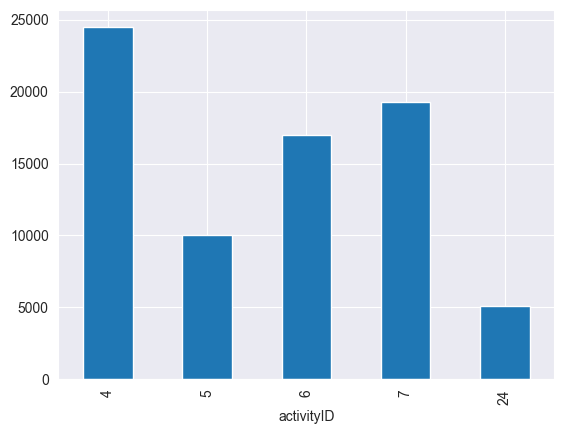

In [8]:
act_data.groupby('activityID').size().plot(kind='bar',
                                       y = 'activityID',
                                       label = "Type",)

## Upsampling

In [9]:
def resampling_df_bycolumn(df, column_name, sampling= 'down', random_state= 1):
    '''Description: This function resamples a pandas DataFrame based on a specified column. The function can be used for either upsampling or downsampling the data. The user can specify the column by name (column_name), and the type of sampling (sampling). The function returns a new resampled DataFrame.

    Parameters:

    df: pandas DataFrame, input data to resample
    column_name: str, name of the column to use for resampling
    sampling: str, optional, default 'down', type of sampling to perform ('up' for upsampling or 'down' for downsampling)
    random_state: int, optional, default 1, seed value for random number generator

    Returns:

    a new resampled DataFrame.
    '''
    from sklearn.utils import resample
    class_unique= df[column_name].unique()
    resample_list= []
    if sampling== 'down':
        n_samples= min(df[column_name].value_counts())
    if sampling== 'up':
        n_samples= max(df[column_name].value_counts())
    for i in range(len(class_unique)):
        resample_list.append(resample(df.loc[df[column_name]== class_unique[i]],
                     replace=True,
                     n_samples= n_samples,
                     random_state= random_state))
    resampled_df= pd.concat(resample_list)
    resampled_df.reset_index(inplace= True)
    resampled_df.drop('index', axis=1, inplace= True)
    return resampled_df

#perguntar se o resampling esta a ser feito para a distribuiçao de cada classe ou no global

In [10]:
data_upsampled_df= resampling_df_bycolumn(act_data, 'activityID', sampling= 'up', random_state= 1)
data_upsampled_df.drop(['timestamp', 'subject_id'], axis= 1, inplace= True)

In [11]:
train_val_df= data_upsampled_df.sample(frac= 0.8, random_state= 1)
test_df= data_upsampled_df.drop(train_val_df.index)

train_val_df.shape[0]+test_df.shape[0]== data_upsampled_df.shape[0] #check if the split has lost any rows. If true no rows were lost. If False some rows were lost in the split

True

In [12]:
train_val_df.shape, test_df.shape

((97852, 41), (24463, 41))

In [13]:
train_val_df.to_csv('train_val_df_upsampled.csv', index=False)
test_df.to_csv('test_df_upsampled.csv', index=False)

In [14]:
train_val_df= pd.read_csv('train_val_df_upsampled.csv')
test_df= pd.read_csv('test_df_upsampled.csv')

In [15]:
features_tv_df= train_val_df.drop(['activityID'], axis= 1, inplace=False)

features_ts_df= test_df.drop(['activityID'], axis= 1, inplace=False)
true_labels_ts= test_df['activityID']
features_tv_df.shape, features_ts_df.shape, true_labels_ts.shape

((97852, 40), (24463, 40), (24463,))

Para utilizar a loss function 'Categorical Crossentropy' é necessário que as target labels sejam dadas no formato one-hot

In [16]:
from sklearn.preprocessing import LabelBinarizer

targets_onehot_tv = LabelBinarizer().fit_transform(train_val_df.activityID)
targets_onehot_tv.shape

(97852, 5)

Dividir o Train/Validation dataset

In [17]:
x_train, x_val, y_train, y_val = train_test_split(features_tv_df, targets_onehot_tv, test_size=0.2, random_state=1)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((78281, 40), (19571, 40), (78281, 5), (19571, 5))

In [18]:
features_test_data= pd.read_csv('features_test_data.csv')

Vão ser utilizados modelos com arquiteturas iguais aos do projeto A

| **Scaler/Modelo** 	| **Simples/GG** 	 | **Grande** 	|
|-------------------	|------------------|------------	|
| **Nada**          	| NS          	    | NG         	|
| **MinMax**        	| MS          	    | MG         	|

Aplicar Min Max Scaling aos dados

In [22]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

#apply scaling to all columns except subject and activity
scalerM = MinMaxScaler()
x_train_s = x_train.copy()
x_val_s = x_val.copy()
x_test_s= features_ts_df.copy()
x_test_data= features_test_data.copy()

x_train_s = scalerM.fit_transform(x_train_s)
x_val_s = scalerM.transform(x_val_s)
x_test_s= scalerM.transform(x_test_s)
x_test_data= scalerM.transform(x_test_data)

pd.DataFrame(x_train_s).describe()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
count,78281.000000,78281.000000,78281.000000,78281.000000,78281.000000,78281.000000,78281.000000,78281.000000,78281.000000,78281.000000,...,78281.000000,78281.000000,78281.000000,78281.000000,78281.000000,78281.000000,78281.000000,78281.000000,78281.000000,78281.000000
mean,0.468868,0.617579,0.720418,0.363927,0.448562,0.642505,0.534011,0.627761,0.562909,0.496951,...,0.519663,0.580540,0.511142,0.576222,0.495937,0.349113,0.450638,0.625741,0.602452,0.499251
std,0.204808,0.214279,0.062126,0.047745,0.039101,0.089479,0.086597,0.052486,0.053583,0.086561,...,0.024897,0.070448,0.083813,0.048104,0.056712,0.049896,0.117473,0.063864,0.110660,0.074219
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.330645,0.484472,0.687840,0.346043,0.431809,0.595951,0.500549,0.605376,0.543252,0.462221,...,0.513154,0.544862,0.482391,0.561720,0.467718,0.330465,0.380066,0.594980,0.520055,0.449908
50%,0.403226,0.596273,0.720183,0.359720,0.448718,0.642569,0.526796,0.628363,0.560955,0.490583,...,0.521063,0.570943,0.503557,0.579804,0.494294,0.353199,0.442475,0.624036,0.593865,0.504440
75%,0.637097,0.801242,0.757009,0.376987,0.471141,0.695081,0.559729,0.658982,0.580913,0.527350,...,0.528106,0.611148,0.535190,0.596178,0.522244,0.374047,0.505250,0.653524,0.688379,0.556381
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
n_features = features_tv_df.shape[1]
n_classes = targets_onehot_tv.shape[1]
n_features, n_classes

(40, 5)

In [24]:
pd.DataFrame(x_test_s).to_csv('scaled_test_features_upsampled.csv', index= False)
true_labels_ts.to_csv('true_labels_ts_upsampled.csv', index= False)
features_ts_df.to_csv('features_ts_df_upsampled.csv', index= False)

pd.DataFrame(x_test_data).to_csv('scaled_features_test_data_us.csv', index= False)

In [25]:
pd.DataFrame(x_test_data).describe()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
count,26808.000000,26808.000000,26808.000000,26808.000000,26808.000000,26808.000000,26808.000000,26808.000000,26808.000000,26808.000000,...,26808.000000,26808.000000,26808.000000,26808.000000,26808.000000,26808.000000,26808.000000,26808.000000,26808.000000,26808.000000
mean,0.397503,0.655165,0.715292,0.361594,0.452833,0.635334,0.529973,0.633778,0.561269,0.492996,...,0.519501,0.582241,0.510253,0.576226,0.496598,0.348515,0.452102,0.627170,0.609715,0.494538
std,0.169790,0.193328,0.054089,0.040511,0.032424,0.077967,0.072475,0.042950,0.043558,0.068766,...,0.021279,0.059888,0.076467,0.040999,0.054528,0.048430,0.116316,0.062138,0.110426,0.070936
min,0.000000,0.000000,0.065381,0.051491,0.045649,0.001042,0.000165,0.017853,0.077247,0.021862,...,0.016002,0.080452,-0.000013,0.007281,0.005956,0.053431,0.022528,-0.005653,-0.021629,0.049611
25%,0.298387,0.534161,0.685680,0.347686,0.436431,0.592388,0.503521,0.611600,0.544626,0.465006,...,0.513434,0.553721,0.484699,0.562540,0.468400,0.329733,0.378673,0.599036,0.528985,0.450650
50%,0.362903,0.633540,0.712915,0.358756,0.450786,0.632931,0.525020,0.631098,0.560365,0.489549,...,0.520612,0.572448,0.502763,0.578972,0.494008,0.352819,0.437842,0.624155,0.601366,0.500540
75%,0.438600,0.807453,0.746064,0.372490,0.470441,0.680099,0.551642,0.658093,0.577267,0.516606,...,0.527037,0.608808,0.531307,0.594263,0.522649,0.373462,0.506571,0.657163,0.695148,0.544356
max,1.000000,1.000000,1.038470,0.895091,1.000000,0.956145,1.000127,1.033175,0.920869,1.072807,...,1.187040,0.999949,0.999873,1.000000,0.959222,1.000000,0.940453,0.984510,1.052597,1.000000


In [27]:
from tensorflow import keras
tf.keras.backend.clear_session()

In [28]:
def compile_fit(model, x_train, y_train, x_val, y_val, epochs):
    '''Description: This function compiles and fits a Keras model using the specified optimizer, loss function, and evaluation metrics. The function trains the model on the given training data and validates the model on the validation data. The function returns a history object that contains the training and validation metrics for each epoch.

    Parameters:

    model: Keras model object, the model to be compiled and fit
    x_train: numpy array, input training data
    y_train: numpy array, target training data
    x_val: numpy array, input validation data
    y_val: numpy array, target validation data
    epochs: int, the number of epochs to train the model for
    Returns:

    history: Keras history object, contains the training and validation metrics for each epoch
    '''
    model.compile(optimizer= 'adam',
                loss= keras.losses.CategoricalCrossentropy(),
                metrics=['categorical_accuracy'])
    history = model.fit(x_train, y_train, batch_size= 128, epochs= epochs, validation_data= (x_val, y_val))

    return history

In [29]:
model_history= {}

In [30]:
NS = tf.keras.Sequential([
    tf.keras.Input(shape=(n_features,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax')])
model_history['NS']= compile_fit(NS, x_train, y_train, x_val, y_val, 20)

Epoch 1/20
612/612 [==============================] - 6s 5ms/step - loss: 0.5971 - categorical_accuracy: 0.8408 - val_loss: 0.2052 - val_categorical_accuracy: 0.9316
Epoch 2/20
612/612 [==============================] - 3s 6ms/step - loss: 0.1422 - categorical_accuracy: 0.9534 - val_loss: 0.1480 - val_categorical_accuracy: 0.9492
Epoch 3/20
612/612 [==============================] - 4s 6ms/step - loss: 0.1005 - categorical_accuracy: 0.9669 - val_loss: 0.0999 - val_categorical_accuracy: 0.9657
Epoch 4/20
612/612 [==============================] - 4s 7ms/step - loss: 0.0773 - categorical_accuracy: 0.9741 - val_loss: 0.0725 - val_categorical_accuracy: 0.9761
Epoch 5/20
612/612 [==============================] - 4s 7ms/step - loss: 0.0661 - categorical_accuracy: 0.9775 - val_loss: 0.0630 - val_categorical_accuracy: 0.9783
Epoch 6/20
612/612 [==============================] - 5s 7ms/step - loss: 0.0538 - categorical_accuracy: 0.9822 - val_loss: 0.0557 - val_categorical_accuracy: 0.9817
Epoc

In [31]:
NG= tf.keras.Sequential([
    tf.keras.Input(shape=(n_features,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation= 'softmax')
])
model_history['NG']= compile_fit(NG, x_train, y_train, x_val, y_val, 20)

Epoch 1/20
612/612 [==============================] - 6s 8ms/step - loss: 0.2505 - categorical_accuracy: 0.9190 - val_loss: 0.0855 - val_categorical_accuracy: 0.9721
Epoch 2/20
612/612 [==============================] - 4s 7ms/step - loss: 0.0782 - categorical_accuracy: 0.9734 - val_loss: 0.0834 - val_categorical_accuracy: 0.9702
Epoch 3/20
612/612 [==============================] - 4s 7ms/step - loss: 0.0522 - categorical_accuracy: 0.9828 - val_loss: 0.0335 - val_categorical_accuracy: 0.9895
Epoch 4/20
612/612 [==============================] - 4s 7ms/step - loss: 0.0428 - categorical_accuracy: 0.9858 - val_loss: 0.0416 - val_categorical_accuracy: 0.9877
Epoch 5/20
612/612 [==============================] - 4s 7ms/step - loss: 0.0362 - categorical_accuracy: 0.9877 - val_loss: 0.0400 - val_categorical_accuracy: 0.9863
Epoch 6/20
612/612 [==============================] - 5s 7ms/step - loss: 0.0341 - categorical_accuracy: 0.9885 - val_loss: 0.0271 - val_categorical_accuracy: 0.9914
Epoc

In [32]:
MG = tf.keras.Sequential([
    tf.keras.Input(shape=(n_features,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax')])
model_history['MG']= compile_fit(MG, x_train_s, y_train, x_val_s, y_val, 20)

Epoch 1/20
612/612 [==============================] - 6s 8ms/step - loss: 0.4091 - categorical_accuracy: 0.8436 - val_loss: 0.2384 - val_categorical_accuracy: 0.9205
Epoch 2/20
612/612 [==============================] - 4s 7ms/step - loss: 0.1110 - categorical_accuracy: 0.9624 - val_loss: 0.0512 - val_categorical_accuracy: 0.9840
Epoch 3/20
612/612 [==============================] - 4s 7ms/step - loss: 0.0598 - categorical_accuracy: 0.9795 - val_loss: 0.0377 - val_categorical_accuracy: 0.9872
Epoch 4/20
612/612 [==============================] - 4s 7ms/step - loss: 0.0614 - categorical_accuracy: 0.9801 - val_loss: 0.0386 - val_categorical_accuracy: 0.9872
Epoch 5/20
612/612 [==============================] - 4s 7ms/step - loss: 0.0358 - categorical_accuracy: 0.9876 - val_loss: 0.0277 - val_categorical_accuracy: 0.9908
Epoch 6/20
612/612 [==============================] - 4s 7ms/step - loss: 0.0361 - categorical_accuracy: 0.9874 - val_loss: 0.0173 - val_categorical_accuracy: 0.9950
Epoc

In [34]:
MS= tf.keras.Sequential([
    tf.keras.Input(shape=(n_features,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation= 'softmax')
])
model_history['MS']= compile_fit(MS, x_train_s, y_train, x_val_s, y_val, 20)

Epoch 1/20
612/612 [==============================] - 5s 7ms/step - loss: 0.6702 - categorical_accuracy: 0.7570 - val_loss: 0.4113 - val_categorical_accuracy: 0.8575
Epoch 2/20
612/612 [==============================] - 3s 5ms/step - loss: 0.3395 - categorical_accuracy: 0.8879 - val_loss: 0.2784 - val_categorical_accuracy: 0.9096
Epoch 3/20
612/612 [==============================] - 3s 6ms/step - loss: 0.2330 - categorical_accuracy: 0.9274 - val_loss: 0.1959 - val_categorical_accuracy: 0.9415
Epoch 4/20
612/612 [==============================] - 4s 7ms/step - loss: 0.1774 - categorical_accuracy: 0.9454 - val_loss: 0.1555 - val_categorical_accuracy: 0.9516
Epoch 5/20
612/612 [==============================] - 3s 5ms/step - loss: 0.1407 - categorical_accuracy: 0.9564 - val_loss: 0.1238 - val_categorical_accuracy: 0.9601
Epoch 6/20
612/612 [==============================] - 4s 6ms/step - loss: 0.1156 - categorical_accuracy: 0.9635 - val_loss: 0.1105 - val_categorical_accuracy: 0.9638
Epoc

In [35]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from  IPython import display

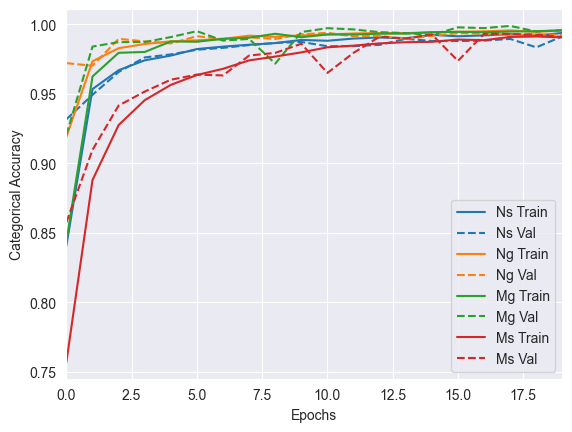

In [36]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'categorical_accuracy')
plotter.plot(model_history)


In [37]:
NS.save('Models Projeto B/NS_us')
NG.save('Models Projeto B/NG_us')
MG.save('Models Projeto B/MG_us')
MS.save('Models Projeto B/MS_us')

INFO:tensorflow:Assets written to: Models Projeto B/NS_us\assets
INFO:tensorflow:Assets written to: Models Projeto B/NG_us\assets
INFO:tensorflow:Assets written to: Models Projeto B/MG_us\assets
INFO:tensorflow:Assets written to: Models Projeto B/MS_us\assets
